# Credit card fraud detector using Amazon Fraud Detector

## Investigate and process the data

In [2]:
from IPython.display import clear_output
from datetime import datetime
from io import StringIO
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTENC
from collections import Counter
from sklearn.metrics import roc_curve, roc_auc_score, auc, roc_auc_score
%matplotlib inline

import os
import sys
import json
import uuid
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import boto3
import time

Let's start by downloading and reading in the credit card fraud data set.

In [1]:
%%bash
wget https://fraud-detector-blog-assets.s3.amazonaws.com/creditcard.csv

--2020-09-22 15:23:31--  https://fraud-detector-blog-assets.s3.amazonaws.com/creditcard.csv
Resolving fraud-detector-blog-assets.s3.amazonaws.com (fraud-detector-blog-assets.s3.amazonaws.com)... 52.216.131.91
Connecting to fraud-detector-blog-assets.s3.amazonaws.com (fraud-detector-blog-assets.s3.amazonaws.com)|52.216.131.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 150828752 (144M) [text/csv]
Saving to: ‘creditcard.csv’

     0K .......... .......... .......... .......... ..........  0%  683K 3m36s
    50K .......... .......... .......... .......... ..........  0%  686K 3m35s
   100K .......... .......... .......... .......... ..........  0%  687K 3m35s
   150K .......... .......... .......... .......... ..........  0%  151M 2m41s
   200K .......... .......... .......... .......... ..........  0%  171M 2m9s
   250K .......... .......... .......... .......... ..........  0%  697K 2m23s
   300K .......... .......... .......... .......... ..........  0% 77

In [31]:
# Resources and env variables setup
s3_resource = boto3.resource('s3')
afd_resource = boto3.client('frauddetector')

# suffix is appended to detector and model name for uniqueness  
sufx = datetime.now().strftime("%Y%m%d")
# replace with the bucket created in the CloudFormation
S3_BUCKET = "afd-poc-trainingbucket-1i37svk9elcoe"
# Replace the ARN Role with the resources created in CloudFormation stack
ARN_ROLE = "arn:aws:iam::387461613214:role/afd-poc-NotebookInstanceExecutionRole-1FNQ41S8H2G68" 

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

data = pd.read_csv('creditcard.csv', delimiter=',')

Let's take a peek at our data (we only show a subset of the columns in the table):

In [6]:
print(data.columns)
data.describe()

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class'], dtype='object')


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [8]:
nonfrauds, frauds = data.groupby('Class').size()
print('Number of frauds: ', frauds)
print('Number of non-frauds: ', nonfrauds)
print('Percentage of fradulent data:', 100.*frauds/(frauds + nonfrauds))

Number of frauds:  492
Number of non-frauds:  284315
Percentage of fradulent data: 0.1727485630620034


The class column corresponds to whether or not a transaction is fradulent. We see that the majority of data is non-fraudulent with only $492$ ($.172\%$), check the Class column mean, of the data corresponding to fraudulent examples.

A PCA have been made lets check the mean and standard deviation of the features.

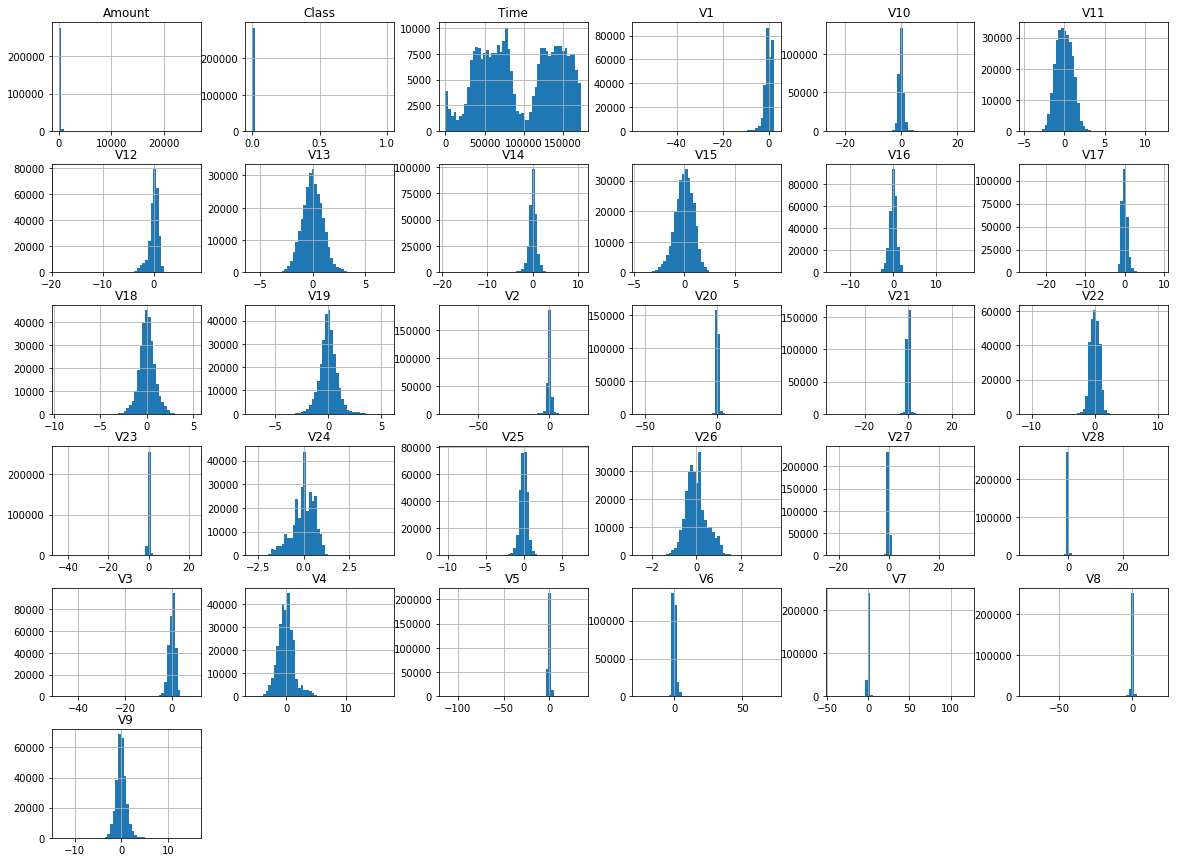

In [7]:
data.hist(bins=50,figsize=(20,15))
plt.show()

Looks good, columns have been normalized to have 0 mean and unit standard deviation as the result of a PCA. Now, lets change the data to be Amazon Fraud Detector compatible.

In [11]:
# to lowercase
data.columns = map(str.lower, data.columns)
print(data.columns)

Index(['time', 'va', 'vb', 'vc', 'vd', 've', 'vf', 'vg', 'vh', 'vi', 'vj', 'vk', 'vl', 'vm', 'vn', 'vo', 'vp', 'vq', 'vr', 'vs', 'vt', 'vu', 'vv', 'vw', 'vx', 'vy', 'vz', 'vaa', 'vab', 'amount', 'class'], dtype='object')


In [10]:
# mapping column names numbers to letters

def standardize_headers(x):
    if any(char.isdigit() for char in x):
        if int(x[1:]) > 26:
            return 'va'+chr(int(x[1:])+70)
        return 'v'+chr(int(x[1:])+96)
    return x

data.rename(columns=standardize_headers, inplace=True)
print(data.columns)

Index(['time', 'va', 'vb', 'vc', 'vd', 've', 'vf', 'vg', 'vh', 'vi', 'vj', 'vk', 'vl', 'vm', 'vn', 'vo', 'vp', 'vq', 'vr', 'vs', 'vt', 'vu', 'vv', 'vw', 'vx', 'vy', 'vz', 'vaa', 'vab', 'amount', 'class'], dtype='object')


Then change the timestamp and label column names

In [14]:
# rename to the Amazon Fraud Detector name conventions 
data.rename(columns={'time':'EVENT_TIMESTAMP','class':'EVENT_LABEL'}, inplace=True)
data.head()

,EVENT_TIMESTAMP,va,vb,vc,vd,ve,vf,vg,vh,vi,vj,vk,vl,vm,vn,vo,vp,vq,vr,vs,vt,vu,vv,vw,vx,vy,vz,vaa,vab,amount,EVENT_LABEL
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,1.341262,0.359894,-0.358091,-0.137134,0.517617,0.401726,-0.058133,0.068653,-0.033194,0.084968,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,-1.416907,-0.153826,-0.751063,0.167372,0.050144,-0.443587,0.002821,-0.611987,-0.045575,-0.219633,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,-0.619468,0.291474,1.757964,-1.323865,0.686133,-0.076127,-1.222127,-0.358222,0.324505,-0.156742,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,-0.705117,-0.110452,-0.286254,0.074355,-0.328783,-0.210077,-0.499768,0.118765,0.570328,0.052736,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,1.017614,0.836390,1.006844,-0.443523,0.150219,0.739453,-0.540980,0.476677,0.451773,0.203711,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


The date column is represented as incremental seconds, lets translate that to real dates.

In [13]:
# Get epoch time for the initial dataset date
epoch = datetime.utcfromtimestamp(0)
def unix_time_seconds(dt):
    return (dt - epoch).total_seconds()

# Lets pretend that the data is from yesterday and could can test at the end with todays date.
start_dt = datetime.strptime('Sep 22 2020  12:00AM', '%b %d %Y %I:%M%p')
start_dt = datetime.now()
start_ep = unix_time_seconds(start_dt)
print(start_ep)

1600788845.180449


Datetime parse test

In [15]:
date_str = '9/22/2020  12:00:00 AM'
date = datetime.strptime(date_str, "%m/%d/%Y %I:%M:%S %p")
print(date)

2020-09-22 00:00:00


Translate the current timestamp format (increasing seconds) to ISO 8601 standard

In [16]:
# translate seconds delta to actual datetimes in ISO 8601
def to_datetime(x):
    current_ep = start_ep + x
    current_dt = time.strftime('%Y-%m-%dT%H:%M:%SZ', time.localtime(current_ep))
    return current_dt


data['EVENT_TIMESTAMP'] = data['EVENT_TIMESTAMP'].apply(to_datetime)
data.head()

,EVENT_TIMESTAMP,va,vb,vc,vd,ve,vf,vg,vh,vi,vj,vk,vl,vm,vn,vo,vp,vq,vr,vs,vt,vu,vv,vw,vx,vy,vz,vaa,vab,amount,EVENT_LABEL
0,2020-09-22T15:34:05Z,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,2020-09-22T15:34:05Z,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,2020-09-22T15:34:06Z,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,2020-09-22T15:34:06Z,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2020-09-22T15:34:07Z,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Lets check for null values

In [17]:
data.isnull().sum()

EVENT_TIMESTAMP    0
va                 0
vb                 0
vc                 0
vd                 0
ve                 0
vf                 0
vg                 0
vh                 0
vi                 0
vj                 0
vk                 0
vl                 0
vm                 0
vn                 0
vo                 0
vp                 0
vq                 0
vr                 0
vs                 0
vt                 0
vu                 0
vv                 0
vw                 0
vx                 0
vy                 0
vz                 0
vaa                0
vab                0
amount             0
EVENT_LABEL        0
dtype: int64

We will split our dataset into a train and test to evaluate the performance of our models. It's important to do so before any techniques meant to alleviate the class imbalance are used. This ensures that we don't leak information from the test set into the train set.

In [ ]:
features = data.drop('EVENT_LABEL', axis=1).values
labels = (data['EVENT_LABEL'].values).astype('float32')

In [19]:
X, X_test, y, y_test = train_test_split(
    features, labels, test_size=0.1, random_state=42)

In [20]:
counter = Counter(y)
print(counter)

Counter({0.0: 255880, 1.0: 446})


Getting the train DataFrame back together

In [22]:
saved_cols = data.drop('EVENT_LABEL', axis=1).columns
print(saved_cols)
data = pd.DataFrame(X, columns = saved_cols)
data['EVENT_LABEL']=y.astype(int)
data.head(10)

Index(['EVENT_TIMESTAMP', 'va', 'vb', 'vc', 'vd', 've', 'vf', 'vg', 'vh', 'vi', 'vj', 'vk', 'vl', 'vm', 'vn', 'vo', 'vp', 'vq', 'vr', 'vs', 'vt', 'vu', 'vv', 'vw', 'vx', 'vy', 'vz', 'vaa', 'vab', 'amount'], dtype='object')


,EVENT_TIMESTAMP,va,vb,vc,vd,ve,vf,vg,vh,vi,vj,vk,vl,vm,vn,vo,vp,vq,vr,vs,vt,vu,vv,vw,vx,vy,vz,vaa,vab,amount,EVENT_LABEL
0,2020-09-22T23:29:20Z,1.22664,0.101988,-0.0870724,0.111524,-0.281992,-1.35603,0.46905,-0.371725,-0.153672,-0.145105,-0.143505,0.320964,0.149313,0.452515,0.776253,0.0287393,-0.177867,-1.00475,0.264953,0.0196923,-0.3551,-1.15366,0.109793,0.420318,0.197932,0.699218,-0.114861,0.00758255,50.4,0
1,2020-09-23T14:39:30Z,1.12485,0.125602,0.249962,0.489744,-0.0403864,0.167561,-0.247614,0.284736,-0.0673023,-0.170139,1.89512,0.507733,-1.00865,0.187249,1.02166,0.13632,0.370186,-0.573559,-0.625413,-0.204465,-0.192467,-0.576819,0.190343,-0.357451,0.000869796,0.139971,-0.000993408,0.0115049,1.98,0
2,2020-09-23T12:33:02Z,-0.307902,1.00371,1.40428,0.592627,0.311014,-0.382106,0.531393,-0.0152922,-0.758638,-0.511597,0.149643,0.245866,0.752802,-0.382214,1.59018,-0.332546,0.611852,-0.510495,0.563779,0.12522,-0.131802,-0.329268,0.04699,0.0574128,-0.65696,0.193192,0.142038,0.157501,1.98,0
3,2020-09-24T11:00:03Z,2.17492,-1.53544,-0.726428,-1.43079,-1.51726,-0.751038,-1.15534,-0.180811,-1.11188,1.5361,-0.735705,-0.771714,0.238603,-0.44705,-0.0858861,-0.568345,0.591162,-0.104975,-0.327292,-0.334351,-0.112766,0.0500184,0.294666,1.12332,-0.306025,-0.241343,0.00655296,-0.0275668,64,0
4,2020-09-24T12:42:48Z,-2.22156,1.26199,2.04764,4.65927,-0.535941,4.54204,-3.71553,-5.3117,-0.955321,0.200601,-1.34262,0.879905,0.241171,-0.36554,-1.73541,0.564495,0.380648,1.21669,1.87271,0.89599,-1.82039,0.873723,-2.6486,-0.16218,-0.492111,0.60149,0.62703,0.088289,379.29,0
5,2020-09-23T23:13:57Z,-0.335198,0.871378,0.632703,4.16424,1.70258,1.95435,0.396722,0.495056,-2.50602,1.60914,1.02925,-0.143569,-0.129187,0.862428,1.05951,-0.862144,0.597711,-0.509967,0.217672,0.260404,0.529635,1.47356,0.0334131,-1.33327,-0.779961,0.595196,0.231547,0.193332,57.78,0
6,2020-09-22T20:44:58Z,-1.30598,1.77212,0.74173,0.912351,0.498898,1.73749,-0.957795,-1.6923,0.755233,-0.641461,0.900131,-0.935381,3.06823,1.56476,-1.35744,-0.216156,0.712878,0.354701,0.95993,-0.579386,1.98545,-1.29011,0.108807,-1.42794,0.140905,-0.393444,0.078297,-0.0525052,1,0
7,2020-09-24T04:38:10Z,-0.303356,1.145,-0.843639,-1.04661,0.945826,-1.8227,1.69451,-0.465604,-0.0954349,-0.150239,-1.00453,-0.509581,-1.0396,0.805069,-0.0770889,-0.649795,-0.363229,-0.307477,-0.163633,0.00746885,0.208148,0.84297,-0.20149,0.0761925,-0.277275,0.0933392,0.497711,0.33648,17,0
8,2020-09-23T15:48:17Z,-0.46592,0.628365,1.44957,4.41735,1.03465,1.08391,0.103565,-0.624355,-0.22619,2.9792,-1.31971,-1.13684,-0.027942,-0.972251,0.758803,-0.104912,-0.462734,0.521972,1.0497,-0.0554636,0.192156,1.23173,-0.113115,0.603061,-1.89004,0.0698536,-0.907822,-0.13317,11.31,0
9,2020-09-23T02:50:52Z,0.271095,-2.72049,0.427427,-0.080256,-2.07731,0.334682,-0.620412,0.174167,0.0874801,0.347286,0.319218,-0.528176,-1.56046,-0.28146,-1.10355,1.18135,0.433565,-0.623177,1.16548,1.06845,0.341998,-0.188797,-0.504412,0.0272953,0.140939,-0.294037,-0.0638468,0.102788,552.89,0


In [23]:
test = pd.DataFrame(X_test, columns = saved_cols)
test.head(10)

,EVENT_TIMESTAMP,va,vb,vc,vd,ve,vf,vg,vh,vi,vj,vk,vl,vm,vn,vo,vp,vq,vr,vs,vt,vu,vv,vw,vx,vy,vz,vaa,vab,amount
0,2020-09-23T03:05:50Z,-16.5265,8.58497,-18.6499,9.50559,-13.7938,-2.8324,-16.7017,7.51734,-8.50706,-14.1102,5.29924,-10.834,1.67112,-9.37386,0.360806,-9.89925,-19.2363,-8.39855,3.10174,-1.51492,1.19074,-1.12767,-2.35858,0.673461,-1.4137,-0.462762,-2.01858,-1.0428,364.19
1,2020-09-23T03:51:46Z,0.339812,-2.74375,-0.13407,-1.38573,-1.45141,1.01589,-0.524379,0.22406,0.899746,-0.565012,-0.0876703,0.979427,0.0768828,-0.217884,-0.13683,-2.14289,0.126956,1.75266,0.432546,0.506044,-0.213436,-0.942525,-0.526819,-1.15699,0.311211,-0.746647,0.0409958,0.102038,520.12
2,2020-09-23T01:25:29Z,1.39959,-0.590701,0.168619,-1.02995,-0.539806,0.0404441,-0.712567,0.00229859,-0.971747,0.756801,0.543827,0.112453,1.07538,-0.245772,0.180483,1.76986,-0.533172,-0.5333,1.19225,0.212877,0.102398,0.168269,-0.166639,-0.81025,0.505083,-0.23234,0.0114086,0.00463414,31
3,2020-09-24T13:59:28Z,-0.432071,1.6479,-1.66936,-0.349504,0.785785,-0.630647,0.27699,0.586025,-0.484715,-1.37665,-1.32834,0.223621,1.13263,-0.550875,0.616568,0.497974,0.502195,0.981343,0.101264,-0.244633,0.358932,0.873663,-0.178642,-0.0171708,-0.207392,-0.157756,-0.237386,0.00193412,1.5
4,2020-09-24T14:21:58Z,2.01416,-0.137394,-1.01584,0.327269,-0.182179,-0.956571,0.0432408,-0.160746,0.363241,0.259452,0.942162,0.850038,-0.616166,0.592634,-0.603845,0.0910772,-0.471867,-0.333816,0.404711,-0.255293,-0.238644,-0.6164,0.347045,0.0615612,-0.360196,0.17473,-0.0780435,-0.0705705,0.89
5,2020-09-23T10:25:23Z,-0.64133,-0.0573039,1.49,-1.68813,-1.15104,0.259996,-1.39107,-2.33408,1.16864,-2.08408,0.480381,0.473738,-2.19228,0.773942,0.294484,0.406074,-0.541855,1.03145,0.0170758,0.618411,-1.23163,0.257164,-0.371953,-0.0385661,1.39751,-0.665947,0.031003,0.180357,100
6,2020-09-24T11:56:48Z,2.02395,-0.12014,-1.08692,0.423019,-0.142901,-1.12775,0.178493,-0.303234,0.564509,0.0628307,-0.720047,0.366835,-0.110857,0.319094,0.108359,-0.153633,-0.221312,-0.934141,0.0705527,-0.210864,-0.276175,-0.697708,0.335631,-0.0171964,-0.324904,0.200023,-0.071566,-0.0582239,16.99
7,2020-09-24T06:21:16Z,-0.688944,1.29215,-0.564281,-1.45753,2.25833,-0.32327,1.67898,-0.104128,-1.28535,-1.30343,0.282728,-0.402525,-0.548687,-0.504283,-0.685339,0.714828,-0.0926736,0.798953,-0.150085,-0.0371504,-0.00687953,-0.171568,-0.720019,-0.419435,1.21199,0.670916,-0.103986,0.0300842,8.95
8,2020-09-24T04:46:29Z,2.11936,0.142639,-2.37334,0.541949,0.608419,-1.77556,0.955775,-0.599383,0.0104198,0.295305,-0.936569,-0.452478,-1.3408,1.07746,-0.0995836,-0.815072,0.0184811,-0.639446,-0.0654267,-0.323573,0.264264,0.898266,-0.168063,0.0593112,0.626949,0.729035,-0.12912,-0.0947133,10
9,2020-09-23T07:53:34Z,-5.58426,-4.73241,-0.448452,-0.121442,-0.707412,-0.114376,-1.55463,1.40213,-0.0316932,-0.942358,-2.4395,-0.552312,-0.295588,-0.250246,-1.19773,1.54955,0.933237,-1.23769,0.416832,-1.0469,0.0416507,0.621789,0.223467,-0.770137,0.621182,-0.0287379,0.505194,-1.89832,101.49


In [24]:
# The testing dataset with the labels to perform evaluations latter on
test_label = pd.DataFrame(X_test, columns = saved_cols)
test_label['EVENT_LABEL']=y_test.astype(int)
test_label.head()

,EVENT_TIMESTAMP,va,vb,vc,vd,ve,vf,vg,vh,vi,vj,vk,vl,vm,vn,vo,vp,vq,vr,vs,vt,vu,vv,vw,vx,vy,vz,vaa,vab,amount,EVENT_LABEL
0,2020-09-23T03:05:50Z,-16.5265,8.58497,-18.6499,9.50559,-13.7938,-2.8324,-16.7017,7.51734,-8.50706,-14.1102,5.29924,-10.834,1.67112,-9.37386,0.360806,-9.89925,-19.2363,-8.39855,3.10174,-1.51492,1.19074,-1.12767,-2.35858,0.673461,-1.4137,-0.462762,-2.01858,-1.0428,364.19,1
1,2020-09-23T03:51:46Z,0.339812,-2.74375,-0.13407,-1.38573,-1.45141,1.01589,-0.524379,0.22406,0.899746,-0.565012,-0.0876703,0.979427,0.0768828,-0.217884,-0.13683,-2.14289,0.126956,1.75266,0.432546,0.506044,-0.213436,-0.942525,-0.526819,-1.15699,0.311211,-0.746647,0.0409958,0.102038,520.12,0
2,2020-09-23T01:25:29Z,1.39959,-0.590701,0.168619,-1.02995,-0.539806,0.0404441,-0.712567,0.00229859,-0.971747,0.756801,0.543827,0.112453,1.07538,-0.245772,0.180483,1.76986,-0.533172,-0.5333,1.19225,0.212877,0.102398,0.168269,-0.166639,-0.81025,0.505083,-0.23234,0.0114086,0.00463414,31,0
3,2020-09-24T13:59:28Z,-0.432071,1.6479,-1.66936,-0.349504,0.785785,-0.630647,0.27699,0.586025,-0.484715,-1.37665,-1.32834,0.223621,1.13263,-0.550875,0.616568,0.497974,0.502195,0.981343,0.101264,-0.244633,0.358932,0.873663,-0.178642,-0.0171708,-0.207392,-0.157756,-0.237386,0.00193412,1.5,0
4,2020-09-24T14:21:58Z,2.01416,-0.137394,-1.01584,0.327269,-0.182179,-0.956571,0.0432408,-0.160746,0.363241,0.259452,0.942162,0.850038,-0.616166,0.592634,-0.603845,0.0910772,-0.471867,-0.333816,0.404711,-0.255293,-0.238644,-0.6164,0.347045,0.0615612,-0.360196,0.17473,-0.0780435,-0.0705705,0.89,0
5,2020-09-23T10:25:23Z,-0.64133,-0.0573039,1.49,-1.68813,-1.15104,0.259996,-1.39107,-2.33408,1.16864,-2.08408,0.480381,0.473738,-2.19228,0.773942,0.294484,0.406074,-0.541855,1.03145,0.0170758,0.618411,-1.23163,0.257164,-0.371953,-0.0385661,1.39751,-0.665947,0.031003,0.180357,100,0
6,2020-09-24T11:56:48Z,2.02395,-0.12014,-1.08692,0.423019,-0.142901,-1.12775,0.178493,-0.303234,0.564509,0.0628307,-0.720047,0.366835,-0.110857,0.319094,0.108359,-0.153633,-0.221312,-0.934141,0.0705527,-0.210864,-0.276175,-0.697708,0.335631,-0.0171964,-0.324904,0.200023,-0.071566,-0.0582239,16.99,0
7,2020-09-24T06:21:16Z,-0.688944,1.29215,-0.564281,-1.45753,2.25833,-0.32327,1.67898,-0.104128,-1.28535,-1.30343,0.282728,-0.402525,-0.548687,-0.504283,-0.685339,0.714828,-0.0926736,0.798953,-0.150085,-0.0371504,-0.00687953,-0.171568,-0.720019,-0.419435,1.21199,0.670916,-0.103986,0.0300842,8.95,0
8,2020-09-24T04:46:29Z,2.11936,0.142639,-2.37334,0.541949,0.608419,-1.77556,0.955775,-0.599383,0.0104198,0.295305,-0.936569,-0.452478,-1.3408,1.07746,-0.0995836,-0.815072,0.0184811,-0.639446,-0.0654267,-0.323573,0.264264,0.898266,-0.168063,0.0593112,0.626949,0.729035,-0.12912,-0.0947133,10,0
9,2020-09-23T07:53:34Z,-5.58426,-4.73241,-0.448452,-0.121442,-0.707412,-0.114376,-1.55463,1.40213,-0.0316932,-0.942358,-2.4395,-0.552312,-0.295588,-0.250246,-1.19773,1.54955,0.933237,-1.23769,0.416832,-1.0469,0.0416507,0.621789,0.223467,-0.770137,0.621182,-0.0287379,0.505194,-1.89832,101.49,0


In [25]:
#validating the test dataset with labels
nonfrauds, frauds = test_label.groupby('EVENT_LABEL').size()
print('Number of frauds in test data: ', frauds)
print('Number of non-frauds in test data: ', nonfrauds)
print('Percentage of fradulent data:', 100.*frauds/(frauds + nonfrauds))

Number of frauds in test data:  46
Number of non-frauds in test data:  28435
Percentage of fradulent data: 0.16151118289385907


Number of frauds:  446
Number of non-frauds:  255880
Percentage of fradulent data: 0.17399717547186005


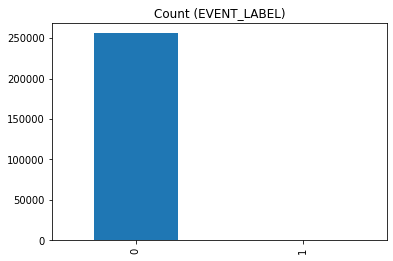

In [26]:
#validating the training dataset
nonfrauds, frauds = data.groupby('EVENT_LABEL').size()
print('Number of frauds: ', frauds)
print('Number of non-frauds: ', nonfrauds)
print('Percentage of fradulent data:', 100.*frauds/(frauds + nonfrauds))

count_class_0, count_class_1 = data.EVENT_LABEL.value_counts()
data.EVENT_LABEL.value_counts().plot(kind='bar', title='Count (EVENT_LABEL)');

Uploading the data for training

In [29]:
csv_buffer = StringIO()
data.to_csv(csv_buffer, index=False)
s3_resource.Object(S3_BUCKET, 'dataset-training.csv').put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': 'CE5955583F8DEF3F',
  'HostId': '9KFf1TqYSU63r33be9Rr6yi3KLpN8eZUEl1bPIaSHbT25EZXtnOG/0nHiFO7lgSAMBXq/qHd6zE=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '9KFf1TqYSU63r33be9Rr6yi3KLpN8eZUEl1bPIaSHbT25EZXtnOG/0nHiFO7lgSAMBXq/qHd6zE=',
   'x-amz-request-id': 'CE5955583F8DEF3F',
   'date': 'Tue, 22 Sep 2020 15:49:02 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"d28f6b034afe0855dc3140edf895eb29"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"d28f6b034afe0855dc3140edf895eb29"',
 'ServerSideEncryption': 'AES256'}

Uploading the data for testing

In [30]:
csv_buffer = StringIO()
test.to_csv(csv_buffer, index=False)

s3_resource.Object(S3_BUCKET, 'dataset-test.csv').put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': '4YAJCW9VAM8XFR4Y',
  'HostId': 'ytH2B37HSHmc1uJeMhHErSg02Zv+MOZa5YrJwrkAZQkTsL9qMOhgWQ3Wwhuufgd58WdWdTSVLto=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'ytH2B37HSHmc1uJeMhHErSg02Zv+MOZa5YrJwrkAZQkTsL9qMOhgWQ3Wwhuufgd58WdWdTSVLto=',
   'x-amz-request-id': '4YAJCW9VAM8XFR4Y',
   'date': 'Tue, 22 Sep 2020 15:49:08 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"d097d1d2e99495c26975acad965d81a5"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"d097d1d2e99495c26975acad965d81a5"',
 'ServerSideEncryption': 'AES256'}

Once we have the datasets ready we need create the necesary entities for build and deploy the fraud detection model. This can be done within the Amazon Fraud Detector console visually or through the API as shown in the following seccion.

In [32]:
# -- This is all you need to fill out. Once complete simply interactively run each code cell. --  
# your_entity_name
ENTITY_TYPE    = "creditcardtrans{0}".format(sufx) 
ENTITY_DESC    = "creditcard transactions: {0}".format(sufx) 
# your_event_type
EVENT_TYPE     = "creditcard{0}".format(sufx) 
EVENT_DESC     = "creditcard card payment events: {0}".format(sufx) 
# your_model_name
MODEL_NAME     = "fraud_detector_model{0}".format(sufx) 
MODEL_DESC     = "model trained on: {0}".format(sufx) 
# your_detector_name
DETECTOR_NAME  = "fraud_detector_endpoint{0}".format(sufx)                        
DETECTOR_DESC  = "detects synthetic fraud events created: {0}".format(sufx) 

### 1. Profile Your Dataset 
-----

    
<div class="alert alert-info"> 💡 <strong> Profiling </strong>

The function below will: 1. profile your data, creating descriptive statistics, 2. perform basic data quality checks (nulls, unique variables, etc.), and 3. return summary statistics and the EVENT and MODEL schemas used to define your EVENT_TYPE and TRAIN your MODEL.


</div>

In [34]:
# --- no changes; just run this code block ---
def summary_stats(df):
    """ Generate summary statistics for a panda's data frame 
        Args:
            df (DataFrame): panda's dataframe to create summary statistics for.
        Returns:
            DataFrame of summary statistics, training data schema, event variables and event lables 
    """
    df = df.copy()
    rowcnt = len(df)
    df_s1  = df.agg(['count', 'nunique']).transpose().reset_index().rename(columns={"index":"feature_name"})
    df_s1["null"] = (rowcnt - df_s1["count"]).astype('int64')
    df_s1["not_null"] = rowcnt - df_s1["null"]
    df_s1["null_pct"] = df_s1["null"] / rowcnt
    df_s1["nunique_pct"] = df_s1['nunique']/ rowcnt
    dt = pd.DataFrame(df.dtypes).reset_index().rename(columns={"index":"feature_name", 0:"dtype"})
    df_stats = pd.merge(dt, df_s1, on='feature_name', how='inner').round(4)
    df_stats['nunique'] = df_stats['nunique'].astype('int64')
    df_stats['count'] = df_stats['count'].astype('int64')
    
    # -- variable type mapper --  
    df_stats['feature_type'] = "UNKOWN"
    df_stats.loc[df_stats["dtype"] == object, 'feature_type'] = "CATEGORY"
    df_stats.loc[(df_stats["dtype"] == "int64") | (df_stats["dtype"] == "float64"), 'feature_type'] = "NUMERIC"
    df_stats.loc[df_stats["feature_name"].str.contains("ipaddress|ip_address|ipcli"), 'feature_type'] = "IP_ADDRESS"
    df_stats.loc[df_stats["feature_name"].str.contains("email|email_address|emailaddr"), 'feature_type'] = "EMAIL_ADDRESS"
    df_stats.loc[df_stats["feature_name"].str.contains("canal|channel"), 'feature_type'] = "USERAGENT"
    df_stats.loc[df_stats["feature_name"].str.contains("monto|amount"), 'feature_type'] = "PRICE"
    df_stats.loc[df_stats["feature_name"].str.contains("nomdes|name"), 'feature_type'] = "BILLING_NAME"
    df_stats.loc[df_stats["feature_name"] == "EVENT_LABEL", 'feature_type'] = "TARGET"
    df_stats.loc[df_stats["feature_name"] == "EVENT_TIMESTAMP", 'feature_type'] = "EVENT_TIMESTAMP"
    
    # -- variable warnings -- 
    df_stats['feature_warning'] = "NO WARNING"
    df_stats.loc[(df_stats["nunique"] != 2) & (df_stats["feature_name"] == "EVENT_LABEL"),'feature_warning' ] = "LABEL WARNING, NON-BINARY EVENT LABEL"
    df_stats.loc[(df_stats["nunique_pct"] > 0.97) & (df_stats['feature_type'] == "CATEGORY") ,'feature_warning' ] = "EXCLUDE, GT 97% UNIQUE"
    df_stats.loc[(df_stats["null_pct"] > 0.2) & (df_stats["null_pct"] <= 0.5), 'feature_warning' ] = "NULL WARNING, GT 20% MISSING"
    df_stats.loc[df_stats["null_pct"] > 0.5,'feature_warning' ] = "EXCLUDE, GT 50% MISSING"
    df_stats.loc[((df_stats['dtype'] == "int64" ) | (df_stats['dtype'] == "float64" ) ) & (df_stats['nunique'] < 0.2), 'feature_warning' ] = "LIKELY CATEGORICAL, NUMERIC w. LOW CARDINALITY"
   
    # -- target check -- 
    exclude_fields  = df_stats.loc[(df_stats['feature_warning'] != 'NO WARNING')]['feature_name'].to_list()
    event_variables = df_stats.loc[(~df_stats['feature_name'].isin(['EVENT_LABEL', 'EVENT_TIMESTAMP']))]['feature_name'].to_list()
    event_labels    = df["EVENT_LABEL"].unique().tolist()
    
    trainingDataSchema = {
        'modelVariables' : df_stats.loc[(df_stats['feature_type'].isin(['IP_ADDRESS', 'EMAIL_ADDRESS', 'CATEGORY', 'NUMERIC' ]))]['feature_name'].to_list(),
        'labelSchema'    : {
            'labelMapper' : {
                'FRAUD' : [str(df["EVENT_LABEL"].value_counts().idxmin())],
                'LEGIT' : [str(df["EVENT_LABEL"].value_counts().idxmax())]
            }
        }
    }
    
    
    model_variables = df_stats.loc[(df_stats['feature_type'].isin(['IP_ADDRESS', 'EMAIL_ADDRESS', 'CATEGORY', 'NUMERIC' ]))]['feature_name'].to_list()
   
    
    # -- label schema -- 
    label_map = {
        'FRAUD' : [df["EVENT_LABEL"].value_counts().idxmin()],
        'LEGIT' : [df["EVENT_LABEL"].value_counts().idxmax()]
    }
    
    
    print("--- summary stats ---")
    print(df_stats)
    print("\n")
    print("--- event variables ---")
    print(event_variables)
    print("\n")
    print("--- event labels ---")
    print(event_labels)
    print("\n")
    print("--- training data schema ---")
    print(trainingDataSchema)
    print("\n")
    
    return df_stats, trainingDataSchema, event_variables, event_labels

# -- connect to S3, snag file, and convert to a panda's dataframe --
#s3   = boto3.resource('s3')
#obj  = s3.Object(S3_BUCKET, S3_FILE)
#body = obj.get()['Body']
#df   = pd.read_csv(body)

# -- call profiling function -- 
df_stats, trainingDataSchema, eventVariables, eventLabels = summary_stats(data)

--- summary stats ---
       feature_name   dtype   count  nunique  null  not_null  null_pct  nunique_pct     feature_type feature_warning
0   EVENT_TIMESTAMP  object  256326   119735     0    256326       0.0       0.4671  EVENT_TIMESTAMP      NO WARNING
1                va  object  256326   248553     0    256326       0.0       0.9697         CATEGORY      NO WARNING
2                vb  object  256326   248553     0    256326       0.0       0.9697         CATEGORY      NO WARNING
3                vc  object  256326   248553     0    256326       0.0       0.9697         CATEGORY      NO WARNING
4                vd  object  256326   248553     0    256326       0.0       0.9697         CATEGORY      NO WARNING
5                ve  object  256326   248553     0    256326       0.0       0.9697         CATEGORY      NO WARNING
6                vf  object  256326   248553     0    256326       0.0       0.9697         CATEGORY      NO WARNING
7                vg  object  256326   2485

### 2. Create Variables
-----

<div class="alert alert-info"> 💡 <strong> Create Variables. </strong>

The following section will automatically create your modeling input variables and your model scoring variable for you. 

</div>

In [ ]:
# --- no changes just run this code block ---
def create_label(df, FRAUD_LABEL):
    """
    Returns a dictionary for the model labelSchema, by identifying the rare event as fraud / and common as not-fraud 
    
    Arguments:
    df          -- input dataframe 
    FRAUD_LABEL -- the name of the field that contains fraud label  
    
    Returns:
    labelSchema -- a dictionary containing labelKey & labelMapper 
    """
    label_summary = df[FRAUD_LABEL].value_counts()
    labelSchema = {'labelKey': FRAUD_LABEL,
                   "labelMapper" : { "FRAUD": [str(label_summary.idxmin())], 
                                     "LEGIT": [str(label_summary.idxmax())]}
                  }
    afd_resource.put_label(
                name = str(label_summary.idxmin()),
                description = 'FRAUD')
    
    afd_resource.put_label(
                name = str(label_summary.idxmax()),
                description = 'LEGIT')
    
    return labelSchema
    
# -- function to create all your variables --- 
def create_variables(df_stats, MODEL_NAME):
    """
    Returns a variable list of model input variables, checks to see if variable exists,
    and, if not, then it adds the variable to Fraud Detector 
    
    Arguments: 
    enrichment_features  -- dictionary of optional features, mapped to specific variable types enriched (CARD_BIN, USERAGENT)
    numeric_features     -- optional list of numeric field names 
    categorical_features -- optional list of categorical features 
    
    Returns:
    variable_list -- a list of variable dictionaries 
    
    """
    enrichment_features = df_stats.loc[(df_stats['feature_type'].isin(['IP_ADDRESS', 'EMAIL_ADDRESS', 'USERAGENT', 'BILLING_NAME', 'PRICE']))]['feature_name'].to_dict()
    enrichment_type = df_stats.loc[(df_stats['feature_type'].isin(['IP_ADDRESS', 'EMAIL_ADDRESS', 'USERAGENT', 'BILLING_NAME', 'PRICE']))]['feature_type'].to_dict()
    numeric_features = df_stats.loc[(df_stats['feature_type'].isin(['NUMERIC']))]['feature_name'].to_dict()
    categorical_features = df_stats.loc[(df_stats['feature_type'].isin(['CATEGORY']))]['feature_name'].to_dict()
    
    variable_list = []
    # -- first do the enrichment features
    for feature in enrichment_features.keys(): 
        variable_list.append( {'name' : enrichment_features[feature]+""})
        try:
            varname = enrichment_features[feature]+""
            afd_resource.get_variables(name=varname)
        except:
            print("Creating variable: {0}".format(enrichment_features[feature]))
            if enrichment_type[feature] == "PRICE":
                resp = afd_resource.create_variable(
                    name = varname,
                    dataType = 'FLOAT',
                    dataSource ='EVENT',
                    defaultValue = '0', 
                    description = enrichment_features[feature],
                    variableType = enrichment_type[feature] )
            else:
                resp = afd_resource.create_variable(
                    name = varname,
                    dataType = 'STRING',
                    dataSource ='EVENT',
                    defaultValue = '<unknown>', 
                    description = enrichment_features[feature],
                    variableType = enrichment_type[feature] )
                
               
    # -- check and update the numeric features 
    for feature in numeric_features: 
        variable_list.append( {'name' : numeric_features[feature]+""})
        try:
            varname = numeric_features[feature]+""
            afd_resource.get_variables(name=varname)
        except:
            print("Creating variable: {0}".format(numeric_features[feature]))
            resp = afd_resource.create_variable(
                    name = varname,
                    dataType = 'FLOAT',
                    dataSource ='EVENT',
                    defaultValue = '0.0', 
                    description = numeric_features[feature],
                    variableType = 'NUMERIC' )
             
    # -- check and update the categorical features 
    for feature in categorical_features: 
        variable_list.append( {'name' : categorical_features[feature]+""})
        try:
            varname = categorical_features[feature]+""
            afd_resource.get_variables(name=varname)
        except:
            print("Creating variable: {0}".format(categorical_features[feature]))
            resp = afd_resource.create_variable(
                    name = varname,
                    dataType = 'STRING',
                    dataSource ='EVENT',
                    defaultValue = '<unknown>', 
                    description = categorical_features[feature],
                    variableType = 'CATEGORICAL' )
    
    # -- create a model score feature  
    model_feature = "{0}_insightscore".format(MODEL_NAME)  
    # variable_list.append( {'name' : model_feature})
    try:
        afd_resource.get_variables(name=model_feature)
    except:
        print("Creating variable: {0}".format(model_feature))
        resp = afd_resource.create_variable(
                name = model_feature,
                dataType = 'FLOAT',
                dataSource ='MODEL_SCORE',
                defaultValue = '0.0', 
                description = model_feature,
                variableType = 'NUMERIC' )
    
    return variable_list


model_variables = create_variables(df_stats, MODEL_NAME)
print("\n --- model variable dict --")
print(model_variables)


model_label = create_label(data, "EVENT_LABEL")
print("\n --- model label schema dict --")
print(model_label)

### 3. Create Entity and Event Types
-----
    
<div class="alert alert-info"> 💡 <strong> Entity and Event. </strong>
    
The following code block will automatically create your entity and event types for you.

</div>

In [ ]:
#Amazon Fraud Detector expect the labels to be strings.
eventLabels = list(map(str, eventLabels))
print(eventLabels)

In [ ]:
# --- no changes just run this code block ---
response = afd_resource.put_entity_type(
    name        = ENTITY_TYPE,
    description = ENTITY_DESC
)
print("-- create entity --")
print(response)

response = afd_resource.put_event_type (
    name           = EVENT_TYPE,
    eventVariables = eventVariables,
    labels         = eventLabels,
    entityTypes    = [ENTITY_TYPE])
print("-- create event type --")
print(response)

### 4. Create & Train your Model
-----
    
<div class="alert alert-info"> 💡 <strong> Train Model. </strong>

The following section will automatically train and activate your model for you. 

</div>

In [ ]:
# -- create our model --
response = afd_resource.create_model(
   description   = MODEL_DESC,
   eventTypeName = EVENT_TYPE,
   modelId       = MODEL_NAME,
   modelType   = 'ONLINE_FRAUD_INSIGHTS')
print("-- initalize model --")
print(response)

In [ ]:
# -- initializes the model, it's now ready to train -- 
S3_FILE        = "dataset-training.csv"
S3_FILE_LOC    = "s3://{0}/{1}".format(S3_BUCKET,S3_FILE)

response = afd_resource.create_model_version(
    modelId     = MODEL_NAME,
    modelType   = 'ONLINE_FRAUD_INSIGHTS',
    trainingDataSource = 'EXTERNAL_EVENTS',
    trainingDataSchema = trainingDataSchema,
    externalEventsDetail = {
        'dataLocation'     : S3_FILE_LOC,
        'dataAccessRoleArn': ARN_ROLE
    }
)
print("-- model training --")
print(response)

In [ ]:
# -- model training takes time, we'll loop until it's complete  -- 
print("-- wait for model training to complete --")
stime = time.time()
while True:
    clear_output(wait=True)
    response = afd_resource.get_model_version(modelId=MODEL_NAME, modelType = "ONLINE_FRAUD_INSIGHTS", modelVersionNumber = '1.0')
    if response['status'] == 'TRAINING_IN_PROGRESS':
        print(f"current progress: {(time.time() - stime)/60:{3}.{3}} minutes")
        time.sleep(60)  # -- sleep for 60 seconds 
    if response['status'] != 'TRAINING_IN_PROGRESS':
        print("Model status : " +  response['status'])
        break
        
etime = time.time()

# -- summarize -- 
print("\n --- model training complete  --")
print("Elapsed time : %s" % (etime - stime) + " seconds \n"  )
print(response)

### 5. Activate the Model and evaluate the performance
-----
    
<div class="alert alert-info"> 💡 <strong> Train Model. </strong>

The following section will automatically train and activate your model for you. 

</div>

In [ ]:
response = afd_resource.update_model_version_status (
    modelId = MODEL_NAME,
    modelType = 'ONLINE_FRAUD_INSIGHTS',
    modelVersionNumber = '1.0',
    status = 'ACTIVE'
)
print("-- activating model --")
print(response)

#-- wait until model is active 
print("--- waiting until model status is active ")
stime = time.time()
while True:
    clear_output(wait=True)
    response = afd_resource.get_model_version(modelId=MODEL_NAME, modelType = "ONLINE_FRAUD_INSIGHTS", modelVersionNumber = '1.0')
    if response['status'] != 'ACTIVE':
        print(f"current progress: {(time.time() - stime)/60:{3}.{3}} minutes")
        time.sleep(60)  # sleep for 1 minute 
    if response['status'] == 'ACTIVE':
        print("Model status : " +  response['status'])
        break
        
etime = time.time()
print("Elapsed time : %s" % (etime - stime) + " seconds \n"  )
print(response)

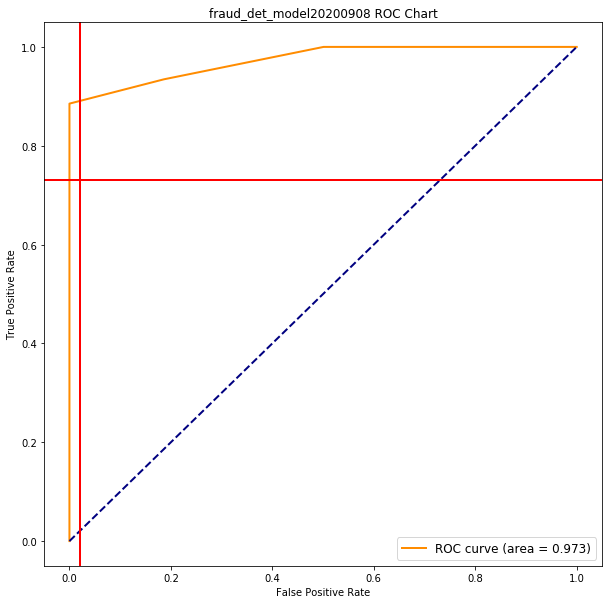

In [28]:
# -- model performance summary -- 
auc = afd_resource.describe_model_versions(
    modelId= MODEL_NAME,
    modelVersionNumber='1.0',
    modelType='ONLINE_FRAUD_INSIGHTS',
    maxResults=10
)['modelVersionDetails'][0]['trainingResult']['trainingMetrics']['auc']


df_model = pd.DataFrame(afd_resource.describe_model_versions(
    modelId= MODEL_NAME,
    modelVersionNumber='1.0',
    modelType='ONLINE_FRAUD_INSIGHTS',
    maxResults=10
)['modelVersionDetails'][0]['trainingResult']['trainingMetrics']['metricDataPoints'])


plt.figure(figsize=(10,10))
plt.plot(df_model["fpr"], df_model["tpr"], color='darkorange',
         lw=2, label='ROC curve (area = %0.3f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title( MODEL_NAME + ' ROC Chart')
plt.legend(loc="lower right",fontsize=12)
plt.axvline(x = 0.02 ,linewidth=2, color='r')
plt.axhline(y = 0.73 ,linewidth=2, color='r')
plt.show()

### 6. Create Detector, generate Rules and assemble your Detector

-----
    
<div class="alert alert-info"> 💡 <strong> Generate Rules, Create and Publish a Detector. </strong>
    
The following section will automatically generate a number of fraud, investigate and approve rules based on the false positive rate and score thresholds of your model. These are just example rules that you could create, it is recommended that you fine tune your rules specifically to your business use case.
</div>

In [ ]:
# -- initialize your detector -- 
response = afd_resource.put_detector(detectorId  = DETECTOR_NAME, 
                               description = DETECTOR_DESC, 
                               eventTypeName = EVENT_TYPE )

print(response)

In [ ]:
# -- make rules -- 
model_stat = df_model.round(decimals=2)  

m = model_stat.loc[model_stat.groupby(["fpr"])["threshold"].idxmax()] 

def make_rule(x):
    rule = ""
    if x['fpr'] <= 0.05: 
        rule = "${0}_insightscore > {1}".format(MODEL_NAME,x['threshold'])
    if x['fpr'] == 0.06:
        rule = "${0}_insightscore <= {1}".format(MODEL_NAME,x['threshold_prev'])
    return rule
    
m["threshold_prev"] = m['threshold'].shift(1)
m['rule'] = m.apply(lambda x: make_rule(x), axis=1)

m['outcome'] = "approve"
m.loc[m['fpr'] <= 0.03, "outcome"] = "fraud"
m.loc[(m['fpr'] > 0.03) & (m['fpr'] <= 0.05), "outcome"] = "investigate"

print (" --- score thresholds 1% to 6% --- ")
print(m[["fpr", "tpr", "threshold", "rule", "outcome"]].loc[(m['fpr'] > 0.0 ) & (m['fpr'] <= 0.06)].reset_index(drop=True))

In [ ]:
# -- create outcomes -- 
def create_outcomes(outcomes):
    """ create Fraud Detector Outcomes 
    
    """   
    for outcome in outcomes:
        print("creating outcome variable: {0} ".format(outcome))
        response = afd_resource.put_outcome(
                          name=outcome,
                          description=outcome)

# -- get distinct outcomes 
outcomes = m["outcome"].unique().tolist()

create_outcomes(outcomes)

In [ ]:
rule_set = m[(m["fpr"] > 0.0) & (m["fpr"] <= 0.06)][["outcome", "rule"]].to_dict('records')
rule_list = []
for i, rule in enumerate(rule_set):
    ruleId = "rule{0}_{1}".format(i, MODEL_NAME)
    rule_list.append({"ruleId": ruleId, 
                      "ruleVersion" : '1',
                      "detectorId"  : DETECTOR_NAME
        
    })
    print("creating rule: {0}: IF {1} THEN {2}".format(ruleId, rule["rule"], rule['outcome']))
    try:
        response = afd_resource.create_rule(
            ruleId = ruleId,
            detectorId = DETECTOR_NAME,
            expression = rule['rule'],
            language = 'DETECTORPL',
            outcomes = [rule['outcome']]
            )
    except:
        print("this rule already exists in this detector")
rule_list

In [ ]:
afd_resource.create_detector_version(
    detectorId = DETECTOR_NAME,
    rules = rule_list,
    modelVersions = [{"modelId":MODEL_NAME, 
                      "modelType" : "ONLINE_FRAUD_INSIGHTS",
                      "modelVersionNumber" : "1.0"}],
    ruleExecutionMode = 'FIRST_MATCHED'
    )

print("\n -- detector created -- ")
print(response) 

In [ ]:
response = afd_resource.update_detector_version_status(
    detectorId= DETECTOR_NAME,
    detectorVersionId='1',
    status='ACTIVE'
)
print("\n -- detector activated -- ")
print(response)

Testing our model endpoint

In [40]:
S3_FILE        = "dataset-test.csv"
S3_FILE_LOC    = "s3://{0}/{1}".format(S3_BUCKET,S3_FILE)

s3_resource.Bucket(S3_BUCKET).download_file(S3_FILE, 'dataset-test.csv')

In [81]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

test = pd.read_csv('dataset-test.csv', delimiter=',')
test.head(10)

,EVENT_TIMESTAMP,tipologia,canal,segmento,rut,dv,ctaori,ctades,nomdes,nombancdes,rutdes,monto,ipcli
0,2020-07-08 11:26:33,Pagos y Transferencias,APP,PF,8b7b9dc18f37bf63f95dd21bc153e392,45c48cce2e2d7fbdea1afc51c7c6ad26,06bb5bef0faf68e34425cfd721ac983e,b59e491ccfc02f404b1be01976b471e0,christian basoalto,Banco de Chile / Edwards-Citi,fd357482b5f76349fc81af3ba52e29b3,199999.0,192.168.88.137
1,2020-07-19 22:06:00,Pagos y Transferencias,APP,PF,c455c3cf1fc59f7e6aa7079b43625395,a87ff679a2f3e71d9181a67b7542122c,9a81863b7b1156dd84576b404efd847b,ee60570fc4f7efbfb4acd953884969e0,maria eugenia gonzalez videla,Banco Santander-Santiago,5845e9d5ed68b3333f8aaffa0f8a110e,130000.0,192.168.88.137
2,2020-07-31 11:59:45,Pagos y Transferencias,APP,PF,9d4d67cab011a7a9e3171d8096d8a5ac,a5f3c6a11b03839d46af9fb43c97c188,2a2a2feb2ee7b91b962937d3df4fa4fd,f54d524ade8984180c9ccb50e74e9768,Cassandra Ornano,Banco Santander-Santiago,e242a0a3af653999d878598dd7025810,15890.0,192.168.88.137
3,2020-07-02 23:42:51,Pagos y Transferencias,WEB,PF,8f0c2c558aed3b7b27961f9102d19bfe,e4da3b7fbbce2345d7772b0674a318d5,ce4b1bbc50cad868d8c9152582bc8652,e3eb10ec1a4ec2a86826f00f8df019ee,Claudio Jara Molina,Banco Santander-Santiago,c72af796f3ce0fae237e1c6b216ceb28,20000.0,186.11.62.185
4,2020-07-02 11:22:15,Pagos y Transferencias,APP,PF,7c56e083a2408573386883ae08da9a72,c9f0f895fb98ab9159f51fd0297e236d,1d2089c0b7a1449669b29fcbe6ffa27b,f0ea88913593ba576a22d67e52dc5b99,hugo muñoz,Banco Falabella,ce846b2b5b17b28180d9e4d160cfd453,120000.0,192.168.88.137
5,2020-07-26 20:07:28,Pagos y Transferencias,WEB,PF,496b9cb13a8ccec4dab279a53555adf6,eccbc87e4b5ce2fe28308fd9f2a7baf3,95b20c920b33cc0ed271ab7eba1c1cd4,b261ea0ad9a0d4065d079906494ce454,matilde maddaleno herrera,Banco de Chile,d216482286e31df42bc1f025e90fd5de,12000.0,201.239.242.46
6,2020-07-21 08:46:07,Pagos y Transferencias,WEB,PJ,d41e62a45537cc9e47da4aa4856beed6,a87ff679a2f3e71d9181a67b7542122c,a3d2de7675556553a5f08e4c88d2c228,a3d2de7675556553a5f08e4c88d2c228,newiol/bic.iol.Transferencias.tef.tefa3ros,IENQ005FP_ConfTrEjecutada,fb21e94fb209a71e831f6019fad298bc,0.0,190.45.200.29
7,2020-07-17 21:32:16,Pagos y Transferencias,APP,PF,fa54fef00d81db63d36ffa08d26c43ff,45c48cce2e2d7fbdea1afc51c7c6ad26,b4ec8b2dd178d847c6df71da9264d352,b12a6281f35a48703dd04ceeac690dac,Laura Vera,Banco Estado,bbddfd8cc3eafb60001c5c06cdc6183b,2300.0,192.168.88.137
8,2020-07-13 21:12:01,Pagos y Transferencias,WEB,PF,7d5e960687d13c11ccce83bd0518d717,c81e728d9d4c2f636f067f89cc14862c,877b46e92286b0aa728e4ae16c65134d,e9b7a87bb5689e44b24a68e033766aea,texia navarro pasten,Banco del Estado de Chile,bcd414eac4268b89b98639b012b6af76,90000.0,201.215.86.174
9,2020-07-17 14:35:05,Pagos y Transferencias,Webmobile,PF,3176e3cf35af1994d3b0ba7a13237d74,c4ca4238a0b923820dcc509a6f75849b,031af4f2f5ea6a3d51e69fd55ddc1903,e634726547937b614ebefa9986a6537e,Cristian aguero,Banco del Estado de Chile,c4c1b24523ef03e3aecc2c6da0a83b55,9000.0,152.231.126.216


Cleaning the test dataset from training columns and defining the start datetime.

In [71]:
record_count = 400
model_variables = [column for column in test.columns if column not in  ['EVENT_LABEL', 'EVENT_TIMESTAMP']]
#dateTimeObj = datetime.strptime('Sep 3 2013  12:00AM', '%b %d %Y %I:%M%p')
dateTimeObj = datetime.now()
timestampStr = dateTimeObj.strftime("%Y-%m-%dT%H:%M:%SZ")
print(' '.join(model_variables))

tipologia canal segmento rut dv ctaori ctades nomdes nombancdes rutdes monto ipcli


In [72]:
import uuid

# test the endpoint with a single prediction.
eventId = uuid.uuid1()
testrecord = test[model_variables].head(15).astype(str).to_dict(orient='records')[6]
pred = afd_resource.get_event_prediction(detectorId=DETECTOR_NAME, 
                                       detectorVersionId='1',
                                       eventId = str(eventId),
                                       eventTypeName = EVENT_TYPE,
                                       eventTimestamp = timestampStr, 
                                       entities = [{'entityType': ENTITY_TYPE, 'entityId':str(eventId.int)}],
                                       eventVariables=  testrecord)
print(pred)

{'modelScores': [{'modelVersion': {'modelId': 'fraud_det_model20200908', 'modelType': 'ONLINE_FRAUD_INSIGHTS', 'modelVersionNumber': '2.0'}, 'scores': {'fraud_det_model20200908_insightscore': 432.0}}], 'ruleResults': [{'ruleId': 'rule1_fraud_det_model20200908', 'outcomes': ['investigate']}], 'ResponseMetadata': {'RequestId': '4e7d4056-fc33-4d26-b6a9-1d9b561bcc89', 'HTTPStatusCode': 200, 'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1', 'date': 'Mon, 14 Sep 2020 20:41:17 GMT', 'x-amzn-requestid': '4e7d4056-fc33-4d26-b6a9-1d9b561bcc89', 'content-length': '277', 'connection': 'keep-alive'}, 'RetryAttempts': 0}}


The next block will use some parallelization to run several test against the fraud detector endpoint.

In [89]:
import dask 
import time
from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:90% }</style>"))

start = time.time()

@dask.delayed
def _predict(record):
    eventId = uuid.uuid1()
    try:
        pred = afd_resource.get_event_prediction(detectorId=DETECTOR_NAME, 
                                       detectorVersionId='1',
                                       eventId = str(eventId),
                                       eventTypeName = EVENT_TYPE,
                                       eventTimestamp = timestampStr, 
                                       entities = [{'entityType': ENTITY_TYPE, 'entityId':str(eventId.int)}],
                                       eventVariables=  record) 
        
        record["score"]   = pred['modelScores'][0]['scores']["{0}_insightscore".format(MODEL_NAME)]
        if len(pred['ruleResults']) > 0:
            record["outcomes"]= pred['ruleResults'][0]['outcomes']
        else:
            record["outcomes"]= 'approve'
        return record
    
    except:
        pred  = afd_resource.get_event_prediction(detectorId=DETECTOR_NAME, 
                                       detectorVersionId='1',
                                       eventId = str(eventId),
                                       eventTypeName = EVENT_TYPE,
                                       eventTimestamp = timestampStr, 
                                       entities = [{'entityType': ENTITY_TYPE, 'entityId':str(eventId.int)}],
                                       eventVariables=  record) 
        record["score"]   = "-999"
        record["outcomes"]= "error"
        return record

predict_data  = test[model_variables].head(record_count).astype(str).to_dict(orient='records')
predict_score = []

i=0
for record in predict_data:
    clear_output(wait=True)
    rec = dask.delayed(_predict)(record)
    predict_score.append(rec)
    i += 1
    print("current progress: ", round((i/record_count)*100,2), "%" )
    
predict_recs = dask.compute(*predict_score)

# Calculate time taken and print results
time_taken = time.time() - start
tps = len(predict_recs) / time_taken

print ('Process took %0.2f seconds' %time_taken)
print ('Scored %d records' %len(predict_recs))

current progress:  100.0 %
Process took 4.35 seconds
Scored 404 records


In [95]:
# lets take a look to the predicted frauds
predictions = pd.DataFrame.from_dict(predict_recs, orient='columns')
predictions.loc[predictions['score'].astype('float32') > 900]

,tipologia,canal,segmento,rut,dv,ctaori,ctades,nomdes,nombancdes,rutdes,monto,ipcli,score,outcomes
401,Sin tipologia,WEB,PF,05ef2b2ec63b0451e753da506407ce59,c4ca4238a0b923820dcc509a6f75849b,8d8b98d0765127cadd3e850af72f8b4d,35298865c6b58ae65570b30e2cfaf83b,victoria,Banco del Estado de Chile,b2d3f8b557944f6780d6d60f7b923eaf,200000.0,186.11.58.2,1000,[fraud]
402,Pagos y Transferencias,WEB,PF,4a379677c0f2edd6a98cebc2c46f4707,45c48cce2e2d7fbdea1afc51c7c6ad26,457ad069eebf1f77dd529fca55e1ec6a,952cd2c29bb380044ecb086d43acdb05,alan cerda,Banco del Estado de Chile,781c1bcc58864eab9c42b5e2a8b40660,200000.0,186.10.157.179,999,[fraud]


In [78]:
data[(data["NomDes"]=="victoria") & (data["RUTDES"]== 'b2d3f8b557944f6780d6d60f7b923eaf')]

,Fecha,Tipología,Canal,Segmento,Rut,Dv,CtaOri,CtaDes,NomDes,NomBancDes,RUTDES,MONTO,Fraude,IPCLI
369910,2020-07-07 12:37:23,NaN,WEB,PF,05ef2b2ec63b0451e753da506407ce59,c4ca4238a0b923820dcc509a6f75849b,8d8b98d0765127cadd3e850af72f8b4d,35298865c6b58ae65570b30e2cfaf83b,victoria,Banco del Estado de Chile,b2d3f8b557944f6780d6d60f7b923eaf,200000.0,SI,186.11.58.2


In [79]:
data[(data["NomDes"]=="alan cerda") & (data["RUTDES"]== '781c1bcc58864eab9c42b5e2a8b40660')]

,Fecha,Tipología,Canal,Segmento,Rut,Dv,CtaOri,CtaDes,NomDes,NomBancDes,RUTDES,MONTO,Fraude,IPCLI
895701,2020-07-16 13:39:57,Pagos y Transferencias,WEB,PF,4a379677c0f2edd6a98cebc2c46f4707,45c48cce2e2d7fbdea1afc51c7c6ad26,457ad069eebf1f77dd529fca55e1ec6a,952cd2c29bb380044ecb086d43acdb05,alan cerda,Banco del Estado de Chile,781c1bcc58864eab9c42b5e2a8b40660,200000.0,SI,186.10.157.179


See the model metrics on CloudWatch and the prediction history in Fraud Detector.

In [ ]:
# save the results to a csv file and upload it to the output s3 bucket
csv_buffer = StringIO()
predictions.to_csv(csv_buffer, index=False)
s3_resource.Object(S3_BUCKET, MODEL_NAME + "precictions{}.csv".format(sufx)).put(Body=csv_buffer.getvalue())

In [ ]:
#data.loc[data['vaa'] == 0.14205158164005, 'vaa':'EVENT_LABEL']

Finish